In [4]:
import sys
sys.path.insert(0, "../")

import h5py
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# make_dataset pipeline
This notebook seeks to explain the data-processing pipeline of our make_dataset.py file. It will take you through each step, going from the raw data to the segmented data with computed KPIs, while explaining the functions and choices made at each step.

<div style="text-align:center">
    <img src="../reports/figures/jupyter/make_dataset/data_warehouse.png" style="width:90%">
</div>

For each step, the command to run the *step* will be stated, and then an explanation of the relevant parts of the code running in the back will be made. Additioanlly, we will showcase what happens to the data after each step. For simplicity, all commands will be listed here for a quick overview.

#### ***Step-by-step***  
**Step 1 - Convert:**       `python src/data/make_dataset.py convert`  
**Step 2 - Validate:**      `python src/data/make_dataset.py validate` (\*)    
**Step 3 - Segment:**       `python src/data/make_dataset.py segment`  
**Step 4 - Match:**         `python src/data/make_dataset.py match`  
**Step 5 - Resample:**      `python src/data/make_dataset.py resample` (\*)  
**Step 6 - KPIs:**           `python src/data/make_dataset.py kpi`

Note that (*) statements also have a verbose functionality that can be added as `--verbose`, where plots and additional tqdm progress bars may be displayed.

#### ***Everything-at-once***  
If you wish to run everything at once simply use the following command, `python src/data/make_dataset.py all`, and adding `--verbose` will still activate at the relevant steps.
#### ***Begin-from-and-do-the-rest***
We added a functionality that allows you to continue from any point in the data-pipeline, meaning e.g. if you have already done `convert`, `validate` and `segment` and wishes to run everything else at once, use the following command, `python src/data/make_dataset.py match --begin-from`. Meaning we run `match` and use the flag `-begin-from` to continue the process.


# Raw data

Before we dive into the data pipeline, lets get an overview of the different datasets we are dealing with. The raw data consists of the 4 datasets:

#### ***1. GM data (AutoPi and CAN)***  

The files `platoon_CPH1_{hh,vh}.hdf5` in the `AutoPi_CAN` folder stores the sensory data from the Green Mobility (GM) cars, measured during the numerous trips driven along a particular route in Copenhagen. The file contains measurements gathered using *Internet of Vehicles* IoV. Some measurements come directly from *CAN bus*, while many of the sensor measurements were captured by a small device called an *AutoPi*.

These measurements are what we intend to use as training data to predict the road condition (in terms of kpi-values). Before this is possible, a number of things have to happen, which are presented later on in this notebook. For now, notice that each sensor stores at least two vectors. The first column is the timestamp of the measurement and the remaining columns store the measured value(s).

>platoon_CPH1_{hh,vh}.hdf5<br>
│── GM<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── Trip ID [int]<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── Pass ID [int]<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── acc.xyz (11359, 4)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── acc_long (16011, 2)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── acc_trans (16011, 2)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── $\ldots$<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── whl_trq_pot_ri (16010, 2)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\cdots$<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\cdots$<br>
$\cdots$ (Not used)


#### ***2. GoPro***

All three GM cars were mounted with a GoPro camera at the front, filming the trips and measuring accelerations and speed using the internal accelerometer and gyroscope of the camera.

Unfortunately, only a subset of the trips actually ended up having GoPro data, and the data is not ordered in the same fashion as the GM data. The measurements are retrieved from meta-data from the GoPro videos using [Online Telemetry Lite](https://goprotelemetryextractor.com/free/), which yields three different csv files: `accl.csv`, `gps5.csv` and `gyro.csv`.

Since the GoPro camera splits the recordings into videos of a fixed lengths, the files are stored in the following structure:

>raw/gopro/<br>
│── car{int}/ [Folder]<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── Recording ID/ [Folder]<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── accl.csv [File]<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── gps5.csv [File]<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── gyro.csv [File]<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\cdots$<br>
$\cdots$

Below, we show all three csv files retrieved from a GoPro recording.

In [2]:
gopro_car_1_recording_1_path = Path("../data/raw/gopro/car1/GH012200")

accl = pd.read_csv(gopro_car_1_recording_1_path / "GH012200_HERO8 Black-ACCL.csv")
accl.head()

,cts,date,Accelerometer (z) [m/s2],Accelerometer (x) [m/s2],Accelerometer (y) [m/s2],temperature [°C]
0,83.619000,2022-08-30T07:49:08.265Z,8.575540,0.676259,4.776978,37.095703
1,88.684386,2022-08-30T07:49:08.270Z,8.565947,0.657074,4.772182,37.095703
2,93.749772,2022-08-30T07:49:08.275Z,8.577938,0.635492,4.757794,37.095703
3,98.815157,2022-08-30T07:49:08.280Z,8.585132,0.659472,4.774580,37.095703
4,103.880543,2022-08-30T07:49:08.285Z,8.573141,0.673861,4.815348,37.095703


In [3]:
gps = pd.read_csv(gopro_car_1_recording_1_path / "GH012200_HERO8 Black-GPS5.csv")
gps.head()

,Unnamed: 0,cts,date,GPS (Lat.) [deg],GPS (Long.) [deg],GPS (Alt.) [m],GPS (2D speed) [m/s],GPS (3D speed) [m/s]
0,0,2503.519,2022-08-30T07:49:10.310Z,55.706031,12.531861,14.348,0.218,1.65
1,1,2594.660,2022-08-30T07:49:10.541Z,55.706035,12.531867,14.432,0.366,1.65
2,2,2685.801,2022-08-30T07:49:10.772Z,55.706030,12.531855,14.474,0.241,1.04
3,3,2776.942,2022-08-30T07:49:11.003Z,55.706028,12.531841,13.302,0.191,0.68
4,4,2868.083,2022-08-30T07:49:11.234Z,55.706024,12.531834,13.053,0.117,0.47


In [4]:
gyro = pd.read_csv(gopro_car_1_recording_1_path / "GH012200_HERO8 Black-GYRO.csv")
gyro.head()

,cts,date,Gyroscope (z) [rad/s],Gyroscope (x) [rad/s],Gyroscope (y) [rad/s],temperature [°C]
0,83.619000,2022-08-30T07:49:08.265Z,-0.001065,0.000000,0.002130,37.095703
1,88.684386,2022-08-30T07:49:08.270Z,0.000000,0.001065,0.002130,37.095703
2,93.749772,2022-08-30T07:49:08.275Z,0.002130,0.001065,0.001065,37.095703
3,98.815157,2022-08-30T07:49:08.280Z,0.002130,0.001065,0.001065,37.095703
4,103.880543,2022-08-30T07:49:08.285Z,0.002130,0.002130,0.000000,37.095703


#### ***3. ARAN***

Road condition data measured by a specialised Automatic Road Analyser (ARAN). For a more detailed description see [the paper](https://doi.org/10.1016/j.dib.2023.109426) section 4. We use this data to compute road condition represented by KPIs, which constitute the targets of the training process.

***NOTE:*** Many values in the ARAN dataset are NaN. Working with the data these values are simply set to 0.

In [5]:
aran_raw = pd.read_csv("../data/raw/ref_data/cph1_aran_hh.csv", sep=';', encoding='unicode_escape')
aran_raw.head()

,L_Route_ID,DCSTimeStamp,BeginChainage,EndChainage,Venstre IRI (m/km),Højre IRI (m/km),Rivninger MeanRI (cm³/m²),Rivninger MeanExistingRI (cm³/m²),Rivninger MeanRPI (cm³/m²),Rivninger MeanAVC (cm³/m²),...,Latitude To (rad),Longitude From (rad),Longitude To (rad),Heading (rad),Elevation (m),Lat,Lon,Alt,Heading,Bearing
0,9990001-0-HVB1,44055.48542,-53.642797,-52.642797,0.0,0.0,NaN,NaN,NaN,NaN,...,0.971321,0.217917,0.217917,1.548209,38.407361,55.652595,12.485727,38.407361,88.705816,89.282278
1,9990001-0-HVB1,44055.48542,-52.642797,-51.642797,NaN,NaN,NaN,NaN,NaN,NaN,...,0.971321,0.217917,0.217917,1.548716,38.409111,55.652596,12.485742,38.409111,88.734917,89.282278
2,9990001-0-HVB1,44055.48542,-51.642797,-50.642797,NaN,NaN,NaN,NaN,NaN,NaN,...,0.971321,0.217917,0.217918,1.549302,38.414436,55.652596,12.485758,38.414436,88.768446,89.271525
3,9990001-0-HVB1,44055.48542,-50.642797,-49.642797,NaN,NaN,28.416636,32.142211,2238.577759,2266.9944,...,0.971321,0.217918,0.217918,1.550076,38.423914,55.652596,12.485774,38.423914,88.812826,89.265799
4,9990001-0-HVB1,44055.48542,-49.642797,-48.642797,NaN,NaN,NaN,NaN,NaN,NaN,...,0.971321,0.217918,0.217918,1.550698,38.431759,55.652596,12.485790,38.431759,88.848426,89.300827


#### ***4. P79***

Not actually used for now, but it is a very precise laser measurement of the surface of the road.
Using a model such as the ***quarter car model*** one can simulate a vehicle driving on the road.

In [6]:
p79_raw = pd.read_csv("../data/raw/ref_data/cph1_zp_hh.csv", sep=';', encoding='unicode_escape')
p79_raw.head()

,Distance [m],Laser 1 [mm],Laser 2 [mm],Laser 3 [mm],Laser 4 [mm],Laser 5 [mm],Laser 6 [mm],Laser 7 [mm],Laser 8 [mm],Laser 9 [mm],...,Laser 22 [mm],Laser 23 [mm],Laser 24 [mm],Laser 25 [mm],Lat,Lon,Højde,GeoHøjde,Alt,Bearing
0,0.000000,77.979963,76.129577,73.432504,72.343552,71.085527,70.748823,71.221280,69.414377,66.948905,...,47.506321,44.715228,42.602378,40.864356,55.652685,12.488391,12.8,38.400002,51.200002,87.366884
1,0.100709,77.577069,75.484964,72.750423,71.660123,70.377488,69.797778,70.464433,69.102455,66.336974,...,47.033870,44.391341,42.129228,41.160619,55.652685,12.488392,12.8,38.400002,51.200002,87.366884
2,0.201419,76.674610,74.928609,72.165267,70.970617,69.588610,69.407065,69.937898,68.307188,65.791922,...,46.652856,44.162898,42.144453,41.047513,55.652685,12.488394,12.8,38.400002,51.200002,87.366884
3,0.302128,76.192724,74.535890,71.536658,70.283476,69.134717,68.887796,69.609289,68.062037,65.154582,...,46.271888,43.681742,41.807248,40.788764,55.652685,12.488396,12.8,38.400002,51.200002,87.366884
4,0.402838,75.589468,73.560795,70.603412,69.809506,68.749661,68.331567,69.250653,67.711902,64.769605,...,45.982650,43.383675,41.542447,40.443700,55.652685,12.488397,12.8,38.400002,51.200002,87.309725


***NOTE*** For the following segments, we explain each step in our data processing pipeline. When ran in notebook it takes significantly longer to complete, thus we advise you to use your terminal. However, expect *Step 1* to take 10-15 minutes regardless of being ran in a terminal.

# Step 1 - Converting data 

**Command:** `python src/data/make_dataset.py convert`

**Code in notebook:**

In [8]:
from src.data.data_functions.converting import convert
from src.data.data_functions.extract_gopro import preprocess_gopro_data

skip_convert = True

if not skip_convert:
    # Convert measurements of GM data
    hh = '../data/raw/AutoPi_CAN/platoon_CPH1_HH.hdf5'
    vh = '../data/raw/AutoPi_CAN/platoon_CPH1_VH.hdf5'
    convert(hh, vh)

    # Convert file structure of GoPro data (comment out if gopro data is not available)
    folder = "../data/raw/gopro/"
    preprocess_gopro_data(folder)

#### ***AutoPi and CAN data***  
The raw data is the CPH1 route from the LiRA data-set, as can be found in [Table 7](https://doi.org/10.1016/j.dib.2023.109426) of the LiRA-CD paper. Our first goal, as described in *section 3* of the paper, is to perform translation (conversion) of some of the car sensors, 

$$
\begin{align*}
    s = ((s_{\text{LiRA-CD}} - b^* \cdot r^*) - b) \cdot r,
\end{align*}
$$
where $s_{LiRA-CD}$ is the sensor signal stored in LiRA-CD, $b^*$ and $r^*$ are the offset and resolution values (values achieved through the CanZE application) and $b$ and $r$ are the corrected offset and resolution values (found in the LiRA project). The values are found in the following [paper](https://doi.org/10.1016/j.dib.2023.109426) and are further specified below,

```Python
CONVERT_PARAMETER_DICT = {
    'acc_long':     {'bstar': 198,      'rstar': 1,     'b': 198,   'r': 0.05   },
    'acc_trans':    {'bstar': 32768,    'rstar': 1,     'b': 32768, 'r': 0.04   },
    'acc_yaw':      {'bstar': 2047,     'rstar': 1,     'b': 2047,  'r': 0.1    },
    'brk_trq_elec': {'bstar': 4096,     'rstar': -1,    'b': 4098,  'r': -1     },
    'whl_trq_est':  {'bstar': 12800,    'rstar': 0.5,   'b': 12700, 'r': 1      },
    'trac_cons':    {'bstar': 80,       'rstar': 1,     'b': 79,    'r': 1      },
    'trip_cons':    {'bstar': 0,        'rstar': 0.1,   'b': 0,     'r': 1      }
}
```
In addition to performing the conversion, we also smooth the data of some of the car sensor signals, as they are prone to noise and can have alot of sporadic behavior. To smoothen the signals we use Locally Weighted Scatterplot Smoothing (LOWESS).

```Python
SMOOTH_PARAMETER_DICT = {
    'acc.xyz':       {'kind': 'lowess', 'frac': [0.005, 0.005, 0.001]},
    'spd_veh':       {'kind': 'lowess', 'frac': [0.005]},
    'acc_long':      {'kind': 'lowess', 'frac': [0.005]},
    'acc_trans':     {'kind': 'lowess', 'frac': [0.005]}
}
```
As evident from the dictionary above, we smooth the different accelerations (x, y and z) with different smoothing parameter (portion of data length). This is due to the fact that smoothing the z-acceleration with a value around $0.005$ makes the resulting data over-smoothened, and it not only removes the noise but also the important fluctutations in the data that may be caused by potholes. Thus, we smooth with $0.001$ in the z-acceleration, and we have the following *before* and *after* smoothing data as shown below,

<div style="text-align:center">
    <img src="..\reports\figures\jupyter\make_dataset\acc_smoothing.png" style="width:80%">
</div>

Finally, we calculate the correlation coefficients between the acceleration data from AutoPi `acc.xyz` and the acceleration data from CAN `acc_trans` and `acc_lon`. Using these correlation coefficients, we reorient the AutoPi data so it maximizes the correlation with the CAN data. This is done since the coordinate systems of the two datasets are not necessarily aligned (and it turns out that they are in fact not!).

# Step 2 - Validation
**Command:** `python src/data/make_dataset.py validate` (`--verbose` can be added)

**Code in notebook:**

In [10]:
from src.data.data_functions.validating import validate

skip_validation = True

if not skip_validation:
    # Validate the GM measurements after conversion
    hh = "../data/interim/gm/converted_platoon_CPH1_HH.hdf5"
    vh = "../data/interim/gm/converted_platoon_CPH1_VH.hdf5"
    validate(hh=hh, vh=vh, threshold=0.9, verbose=False)

To validate that our conversions have been done correctly and the smoothing with LOWESS has improved the signal, we wish to compare the the AutoPi data with that of CAN.

#### Process data for comparison
1. We fix the sampling frequency (used to calculate the time) to $f_s=10$.
2. Extract the speed distance calculated based on the vehicle speed from the GM data (`spd_veh`).
3. Extract GPS (`gps`) longtitude and latitude data.
4. Extract Odometer (`odo`) distance measure and adding the fine distance measure (`f_dist`), all computed in meters.
5. Extract and normalise AutoPi 3D accelerations (`acc.xyz`).
6. Extract and normalise transverse (`acc_trans`) and longitudinal (`acc_long`) acceleration.
7. Resample time into 100Hz
8. Resample all extracted data into 100Hz via interpolation in the function clean_int($\cdot$).
9. Ensure accelerations are in $m/s^2$ and not $g$.

#### Compare and calculate normalised MSE
1. Compare x-accelerations
2. Compare y-accelerations
3. Compare speed distance with gps and speed distance with odometer.

**NOTE**: This step does not change the structure of the data.

Below we see examples for each of the three comparisons made in our validation step.

<div style="text-align:center">
    <img src="..\reports\figures\jupyter\make_dataset\validate_data.png" style="width:80%">
</div>

As seen from the plot above, we have the the data from AutoPi and CAN follow each other relatively good with normalised MSE below our threshold of 0.2.

# Step 3 - Segment

**Command:** `python src/data/make_dataset.py segment` (`--verbose` can be added)

**Code in notebook:**

In [12]:
from src.data.data_functions.segmenting import segment

skip_segment = True

if not skip_segment:
    # Validate the GM measurements after conversion
    hh = "../data/interim/gm/converted_platoon_CPH1_HH.hdf5"
    vh = "../data/interim/gm/converted_platoon_CPH1_VH.hdf5"
    speed_threshold = 5
    time_threshold = 10
    segment(hh=hh, vh=vh, speed_threshold=speed_threshold, time_threshold=time_threshold)

The following segmentation step is *only* done on the ***GM*** data, and it arises from the observation that data from time-stamps where the car is (close to) stationary i.e. is sitting in traffic or at a traffic light adds little to no information about the road profile. To accounting for this, we split all trips and passes for all cars into segments, and restructure the hdf5 tree into the following.

#### The restructured data
>segments.hdf5<br>
│── Segment ID [int]<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── *attributes*<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── *direction* [str]<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── *trip_name* [str]<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── *pass_name* [str]<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── acc.xyz [array] (1805, 4)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── acc_long [array] (2550, 2)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── acc_trans [array] (2550, 2)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── $\cdots$<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── whl_trq_pot_ri [array] (2548, 2)<br>
│── $\cdots$<br>
$\cdots$

As can be seen in the new data-structure, we reformat the data such that the direction, trip-name and pass-name all are saved as attributes in each segment, instead of it being a hiearchy going from `direction -> trip-name -> pass-name -> measurements` we now have `segment -> {direction, trip-name, pass-name}, measurements`. By doing this, we allow for a more comprehensible work-flow when training machine learning models.

**Now, how do we do it?** To asses whether a car is stationary or almost stationary we say that if the speed is less than the `speed_threshold` for more than `time_threshold` seconds, then we *clip* it out and split it into segments. For our data, we used,

- `speed_threshold = 5` 
- `time_threshold = 10` 

#### Illustration of segments

The code below loads the converted ***GM*** data and the segmented ***GM*** data and displays a few examples of how passes are segmented into segments of various sizes.

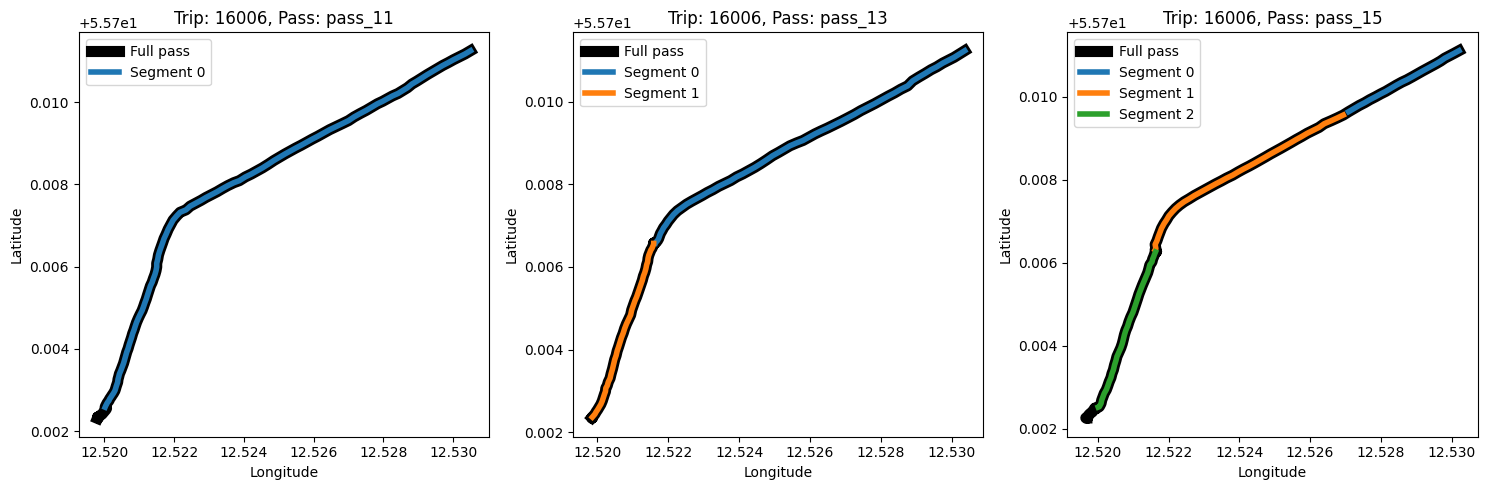

In [13]:
# Choose direction
direction = "hh"

# Load converted data
converted = f"../data/interim/gm/converted_platoon_CPH1_{direction.upper()}.hdf5"

# Load the segmented data
segments = "../data/interim/gm/segments.hdf5"

# Plot the original coordinates for the chosen passes and overlay the segments
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Choose some arbitrary passes to plot
trip_name = "16006"
pass_names = ["pass_11", "pass_13", "pass_15"]

with h5py.File(converted, 'r') as f_convert:
    GM = f_convert['GM']
    with h5py.File(segments, 'r') as f_segments:
        for pass_name, ax in zip(pass_names, axes):
            # Extract pass data
            car_passes = GM[trip_name]
            pass_ = car_passes[pass_name]

            # Get the latitude and longitude
            gps = pass_['gps'][:, 1:]
            lat = gps[:, 0]
            lon = gps[:, 1]

            ax.plot(lon, lat, linewidth=8, label='Full pass', color='black')

            # Extract the segments for the chosen passes using the attributes of the segments in the hdf5 file
            # Overlay the segments on the plots of the passes
            segment_index = 0
            for segment in f_segments.values():
                # Check if the segment comes from the same trip and pass
                if segment.attrs['trip_name'] != trip_name or segment.attrs['pass_name'] != pass_name:
                    continue

                # Get the latitude and longitude
                gps = segment['gps'][:, 1:]
                lat = gps[:, 0]
                lon = gps[:, 1]

                ax.plot(lon, lat, linewidth=4, label=f'Segment {segment_index}')
                segment_index += 1

            ax.set_title(f"Trip: {trip_name}, Pass: {pass_name}")
            ax.set_xlabel('Longitude')
            ax.set_ylabel('Latitude')
            ax.legend()

plt.tight_layout()
plt.show()

# Step 4 - Match
**Command:** `python src/data/make_dataset.py match`

**Code in notebook:**

In [16]:
from src.data.data_functions.matching import match_data

skip_match = True

if not skip_match:
    aran_hh = "../data/raw/ref_data/cph1_aran_hh.csv"
    aran_vh = "../data/raw/ref_data/cph1_aran_vh.csv"
    p79_hh = "../data/raw/ref_data/cph1_zp_hh.csv"
    p79_vh = "../data/raw/ref_data/cph1_zp_vh.csv"
    p79_iri_rut_hh = "../data/raw/ref_data/cph1_iri_mpd_rut_hh.csv"
    p79_iri_rut_vh = "../data/raw/ref_data/cph1_iri_mpd_rut_vh.csv"

    # Matching the reference data and the GoPro data with the segments of the GM data
    match_data(aran_hh, aran_vh, p79_hh, p79_vh, p79_iri_rut_hh, p79_iri_rut_vh, skip_gopro=False)

Now that we have extracted the segments of the GM data which *hopefully* contain meaningful measurements, we simply need to extract the corresponding segments from the three other datasets, namely: ***GoPro***, ***ARAN*** and ***P79***.

In the case of the ***GoPro*** data, we can not find the appropriate data for each segment using the longitudal and lattitudal coordinates, since each car drove multiple labs on the route.
Therefore, we instead simply match the segments using the timestamps of the beginning and end measurements in each segment with the timestamps of the ***GoPro*** data.

The ***ARAN*** and ***P79*** data contains only a single lab of the route (which is a subsection of the entire route of the refrence data cars). Therefore, we can match up the reference data measurements with the GM segments by finding comparing the longitudal and lattitudal coordinates of the reference data with the coordinates of the beginning and end measurements in each GM segment.

The matching segments for ***GoPro***, ***ARAN*** and ***P79*** are stored in seperate `segments.hdf5` files within each appertaining folders in the `interim/gopro`, `interim/aran` and `interim/p79`.


**NB** The p79 data contain a lot of NaN values in the columns used to calculate the IRI and RUT KPIs in the next step, and to account for this we simply merge the relevant data from the files called `cph1_iri_mpd_rut_hh.csv` and `cph1_iri_mpd_rut_vh.csv` to get a more accurate measurement of the indices. Note that the p79 data has a 0.1m resolution whereas the `*iri_mpd_rut*` files are measured in 10m resolution. When merging we simply loop accross the rows in `*iri_mpd_rut*` and create a boolean mask of the rows in p79 that are contained in the distance interval. This means that for the first row, we have that all distance values in p79 that satisify `(distance >=0) & (distance < 10)` get the same values, etc. etc.

### Segment data structures

For complete clarity, we show the structure of the interim segment data for ***GoPro***, ***ARAN*** and ***P79***, in line with how ***GM*** was represented in the previous section.

#### ***GoPro***

>interim/gopro/segments.hdf5<br>
│── Segment ID [int]<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── *attributes*<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── *direction* [str]<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── *trip_name* [str]<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── *pass_name* [str]<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── accl<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── 'Accelerometer (x) [m_s2]' [array] (4911,)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── 'Accelerometer (y) [m_s2]' [array] (4911,)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── 'Accelerometer (z) [m_s2]' [array] (4911,)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── cts [array] (4911,)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── date [array] (4911,)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── 'temperature [°C]' [array] (4911,)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── gps5<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── 'GPS (2D speed) [m_s]' [array] (442,)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── 'GPS (3D speed) [m_s]' [array] (442,)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── 'GPS (Alt.) [m]' [array] (442,)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── 'GPS (Lat.) [deg]' [array] (442,)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── 'GPS (Long.) [deg]' [array] (442,)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── cts [array] (442,)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── date [array] (442,)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── gyro<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── 'Gyroscope (x) [rad_s]' [array] (4911,)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── 'Gyroscope (y) [rad_s]' [array] (4911,)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── 'Gyroscope (z) [rad_s]' [array] (4911,)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── cts [array] (4911,)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── date [array] (4911,)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── 'temperature [°C]' [array] (4911,)<br>
│── $\cdots$<br>
$\cdots$


#### ***ARAN***

>interim/aran/segments.hdf5<br>
│── Segment ID [int]<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── *attributes*<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── *direction* [str]<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── *trip_name* [str]<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── *pass_name* [str]<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── Alt [array] (309,)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── Bearing [array] (309,)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── BeginChainage [array] (309,)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── $\ldots$<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── 'Venstre Wheelpath Texture MPD (mm)' [array] (309,)<br>
│── $\cdots$<br>
$\cdots$


#### ***P79***

>interim/p79/segments.hdf5<br>
│── Segment ID [int]<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── *attributes*<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── *direction* [str]<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── *trip_name* [str]<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── *pass_name* [str]<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── GeoHøjde [array] (3061,)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── Højde [array] (3061,)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── 'Laser 1 [mm]' [array] (3061,)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── $\ldots$<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── Lon [array] (3061,)<br>
│── $\cdots$<br>
$\cdots$

# Step 5 - Resample
**Command:** `python src/data/make_dataset.py resample` (`--verbose` can be added)

**Code in notebook:**

In [3]:
from src.data.data_functions.resampling import resample

skip_resample = True

if not skip_resample:

    gm_file = "../data/interim/gm/segments.hdf5"
    aran_file = "../data/interim/aran/segments.hdf5"
    p79_file = "../data/interim/p79/segments.hdf5"
    gopro_file = "../data/interim/gopro/segments.hdf5"

    # Resampling the data to a common time base
    resample(gm_file, aran_file, p79_file, gopro_file, skip_gopro=False, verbose=False)

Finally, we are ready to combine the 4 datasets into a single dataset with input data (***GM*** and ***GoPro***) and appertaining targets (***ARAN*** and ***P79***).

However, as it currently stands with the input data, all sensors measure values with different frequencies, meaning that in order to line up the input data as $X_j = \begin{bmatrix}\boldsymbol{x_1}, \boldsymbol{x_2}, \ldots, \boldsymbol{x_n}\end{bmatrix}^T$, where $\boldsymbol{x_i}$ is a vector of a single measurement from each relevant sensor (*hopefully*) at the same location on the road, we need to resample the measurements from each sensor to a fixed frequency (chosen to be 250Hz). This is achieved using simple linear interpolation with respect to the relative time driven in each segment.

Afterwards, each segment is split into data points $X_j$, called *bits*, corresponding of 250 resampled measurements of each sensor. For each *bit*, we then extract the corresponding target data from ***ARAN*** and ***P79*** by finding the closest longitudal and lattitudal coordinates, like in step 4, Matching.

The end result is a single hdf5-file of processed and (*hopefully*) well-aligned data, which is stored in the file `processed/wo_kpis/segments.hdf5`. The naming `wo_kpis` is short for *with out kpis", as they still need to be computed from the ***ARAN*** *bits*. This process is described in the next step.

#### The processed data (with out kpis)
>processed/wo_kpis/segments.hdf5<br>
│── Segment ID [int]<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── *attributes*<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── *direction* [str]<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── *trip_name* [str]<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── *pass_name* [str]<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── Second [int]<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── aran [array] (14, 79)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── *attributes*<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── *col_name* [str] : *col_idx* [int]<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── gm [array] (250, 42)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── *attributes*<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── *col_name* [str] : *col_idx* [int]<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── gopro [array] (250, 15)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── *attributes*<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── *col_name* [str] : *col_idx* [int]<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── p79 [array] (128, 32)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── *attributes*<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── *col_name* [str] : *col_idx* [int]<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── Second [int]<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── $\cdots$<br>
│── $\cdots$<br>
$\cdots$

# Step 6 - KPIs
**Command:** `python src/data/make_dataset.py kpi`

**Code in notebook:**

In [7]:
from src.data.data_functions.kpis import compute_kpis

skip_kpi = True

if not skip_kpi:
    segment_path = "../data/processed/wo_kpis/segments.hdf5"
    window_sizes = [1, 2]
    compute_kpis(segment_path=segment_path, window_sizes=window_sizes)

We are interested in certain Key Performance indices (KPIs) that we wish to predict at the end of our pipeline with a machine learning model. For each second in each segment, we calculate KPIs based on a specified window size. We compute the KPIs based on the LiRA practical guide, but with some small variantions.

In [Practical Guide](https://books.google.dk/books/about/Live_Road_Assessment_Based_on_Modern_Car.html?id=EW0d0AEACAAJ&redir_esc=y),  Skar et al. present the following five distress types for which they calculate a Damage Index (DI) and a Key Performance Index (KPI):
\begin{align*}
    \text{CrackingSum} &=  (\text{LCS}^2+\text{LCM}^3+\text{LCM}^4 +\text{LCSe}^2+3 \text{TCS} +4 \text{TCM}+5 \text{TCL}+2\text{TCSe})^{0.1} \\
    \text{AlligatorSum} &=  (3\text{ACS} + 4\text{ACM} + 5\text{ACL})^{0.3} \\
    \text{PotholesSum} &=  (5\text{PAS}+7 \text{PAM}+10 \text{PAL}+5 \text{PAD})^{0.1} \\
    \text{RuttingMean} &= ((\text{RDL} + \text{RDR})/2)^{0.5} \\
    \text{IRIMean} &=  ((\text{IRL} + \text{IRR})/2)^{0.2}
\end{align*}
where the first two letters of each variable of the equations are used to identify the distress type or a road property: *LC* is Longitudinal Cracks, *TC* is Transversal Cracks, *AC* is Alligator Cracks, *PA* is Pothole Areas, *RD* is Rutting Depth, and *IR* is the International Roughness Index. The third letter defines the class: *S* is Small, *M* is Medium, *L* is Large, *Se* is Sealed, and *D* is Delamination; in the last two equations, the third letter specifies the wheel path: *L* stands for Left and *R* for Right.

Based on the information from ["Road Profile Inversion from In-Vehicle Accelerometers"](https://doi.org/10.1061/JPEODX.PVENG-1385) by Skar et al. and conversations with our supervisor, it was deemed favourable to have an additional index for when patching occurs on the road. It is a reoccurring problem for "Vejdirektoratet" that they do not know where they have patched previous potholes; we propose an additional metric called PatchIndex (PI), which in turn alters the CrackingSum metric,

\begin{align*}
    \text{PatchingSum} &= (\text{LCSe}^2 + 2\text{TCSe})^{0.4}\\
    \text{CrackingSum} &=  (\text{LCS}^2+\text{LCM}^3+\text{LCM}^4+3 \text{TCS} +4 \text{TCM}+5 \text{TCL})^{0.1} \\
    \text{AlligatorSum} &=  (3\text{ACS} + 4\text{ACM} + 5\text{ACL})^{0.3} \\
    \text{PotholesSum} &=  (5\text{PAS}+7 \text{PAM}+10 \text{PAL}+5 \text{PAD})^{0.1} \\
    \text{RuttingMean} &= ((\text{RDL} + \text{RDR})/2)^{0.5} \\
    \text{IRIMean} &= ((\text{IRL} + \text{IRR})/2)^{0.2}
\end{align*}
and our tailored KPIs then become
\begin{align*}
    \text{KPI}_{\text{DI}} &= \text{CrackingSum} + \text {AlligatorSum} + \text{PotholesSum} \\
    \text{KPI}_{\text{RUT}} &= \text{RuttingMean}\\
    \text{KPI}_{\text{PI}} &= \text{PatchingSum} \\
    \text{KPI}_{\text{IRI}} &= \text{IRIMean}\\
\end{align*}

**NOTE**: With these new KPI values for each second, we get the final structure of the processed data.

#### The complete processed data
>processed/w_kpis/segments.hdf5<br>
│── Segment ID [int]<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── *attributes*<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── *direction* [str]<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── *trip_name* [str]<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── *pass_name* [str]<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── Second [int]<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── aran [array] (14, 79)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── *attributes*<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── *col_name* [str] : *col_idx* [int]<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── gm [array] (250, 42)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── *attributes*<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── *col_name* [str] : *col_idx* [int]<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── gopro [array] (250, 15)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── *attributes*<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── *col_name* [str] : *col_idx* [int]<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── p79 [array] (128, 32)<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── *attributes*<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── *col_name* [str] : *col_idx* [int]<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── kpis [array]<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── window_size[0] [array] (4, )<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── window_size[1] [array] (4, )<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── Second [int]<br>
│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│── $\cdots$<br>
│── $\cdots$<br>
$\cdots$

## Training Data

#### ***NOTE:***
In the training process, we will only deal with the ***GM*** and (*possibly*) the ***GoPro*** parts as training data. The targets of the training process are the ***KPIs***, calculated in step 6, so the ***ARAN*** and ***P79*** parts are no longer relevant.